In [1]:
import os
import numpy as np
import torch
import importlib
import consts
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from scipy.spatial.distance import cdist
from scipy.stats import ortho_group
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pyLDAvis
from toolbox.alias_multinomial import AliasMultinomial

# 重新載入 consts 以確保變數最新
importlib.reload(consts)
torch.manual_seed(consts.SEED)
np.random.seed(consts.SEED)

c:\Users\wise\.conda\envs\py10\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# 確保輸出目錄存在
output_dir = "newsgroup_test"
os.makedirs(output_dir, exist_ok=True)

# ✅ 下載 20 Newsgroups 資料集並轉換為 BoW
categories = None
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))

vectorizer = CountVectorizer(max_features=5000, stop_words='english', token_pattern=r'(?u)\b[A-Za-z]{3,}\b')# 只允許至少 3 個英文字母的單詞
X_train = vectorizer.fit_transform(newsgroups_train.data).toarray()
X_test = vectorizer.transform(newsgroups_test.data).toarray()
vocab = vectorizer.get_feature_names_out()
y_train = np.array(newsgroups_train.target)
y_test = np.array(newsgroups_test.target)

In [3]:
# ✅ 產生 word_counts 與 doc_lens
word_counts = np.sum(X_train, axis=0)
doc_lens_train = np.sum(X_train, axis=1)
doc_lens_test = np.sum(X_test, axis=1)

In [4]:
# ✅ 轉換為 PyTorch Tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

In [5]:
# ✅ 產生 doc_windows（上下文窗口）
def get_windows(bow_matrix, window_size=5):
    n_docs, vocab_size = bow_matrix.shape
    windows = []
    for doc_idx in range(n_docs):
        indices = np.nonzero(bow_matrix[doc_idx])[0]
        if len(indices) >= window_size:
            for i in range(len(indices) - window_size + 1):
                window = indices[i:i+window_size]
                windows.append([doc_idx] + list(window))
    return np.array(windows)

doc_windows = get_windows(X_train)

In [6]:
# ✅ 自訂 PyTorch Dataset
class DocWindowsDataset(Dataset):
    def __init__(self, windows):
        self.data = windows

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.long)

In [17]:
# ✅ 概念挖掘模型
class GuidedDiverseConceptMiner(nn.Module):
    def __init__(self, vocab, vocab_size, nconcepts=10, embed_dim=50, nnegs=15, lam=100.0, rho=100.0, eta=1.0, bow_train=None, y_train=None, doc_windows=None, word_counts=None):
        super(GuidedDiverseConceptMiner, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        device = torch.device(self.device)
        self.vocab=vocab
        self.nconcepts = nconcepts
        self.nnegs = nnegs
        self.lam = lam
        self.rho = rho
        self.eta = eta
        self.alpha = 1.0 / nconcepts
        self.embedding_i = nn.Embedding(vocab_size, embed_dim).to(self.device)
        self.embedding_t = nn.Parameter(torch.FloatTensor(ortho_group.rvs(embed_dim)[0:nconcepts])).to(self.device)
        self.doc_concept_weights = nn.Embedding(bow_train.shape[0], nconcepts).to(self.device)
        self.docweights = torch.ones(bow_train.shape[0], dtype=torch.float32, device=self.device)
        self.train_dataset = DocWindowsDataset(doc_windows)
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(nconcepts, 1).to(self.device)

        self.bow_train = torch.tensor(bow_train, dtype=torch.float32, requires_grad=False, device=self.device)

        #negative sampling的權重
        wf = np.power(word_counts, 0.75)
        self.word_counts=word_counts
        wf = wf / np.sum(wf)
        self.weights = torch.tensor(wf, dtype=torch.float32, requires_grad=False, device=device)
        
        self.dropout1 = nn.Dropout(consts.PIVOTS_DROPOUT)
        self.dropout2 = nn.Dropout(consts.DOC_VECS_DROPOUT)
        self.multinomial = AliasMultinomial(wf, self.device)

    def forward(self, doc, target, contexts):
        batch_size = contexts.size(0)
        window_size = contexts.size(1)
        #用文件長度重新調整loss權重
        w = autograd.Variable(self.docweights[doc.data]).to(self.device)
        w /= w.sum()
        w *= w.size(0)

        doc_concept_probs = F.softmax(self.doc_concept_weights(doc), dim=1).to(self.device) #計算每個文件與不同概念的關聯程度
        concept_embeddings = self.embedding_t.expand(batch_size, -1, -1) #把embedding_t(概念向量)展開，讓它的形狀從(nnconcepts, embed_dim)，變成(batch_size, nnconcepts, embed_dim)，為了下一步torch.bmm的計算
        doc_vector = torch.bmm(doc_concept_probs.unsqueeze(1), concept_embeddings).squeeze(1) #doc_vector，代表每個文件的最終向量表示，用來計算概念權重，影響預測結果。(batch_size, 1, nnconcepts) x (batch_size, nnconcepts, embed_dim) = (batch_size, 1, embed_dim)
        
        #sample negative word indices for negative sampling loss; approximation by sampling from the whole vocab
        nwords = self.multinomial.draw(batch_size * window_size * self.nnegs)
        nwords = autograd.Variable(nwords).view(batch_size, window_size * self.nnegs)

        #計算word vectors
        ivectors = self.dropout1(self.embedding_i(target)) #目標詞向量
        ovectors = self.embedding_i(contexts) #上下文詞向量
        nvectors = self.embedding_i(nwords).neg() #負樣本詞向量

        context_vectors = doc_vector + ivectors
        context_vectors = context_vectors.unsqueeze(2)

        #計算negative sampling loss
        oloss = torch.bmm(ovectors, context_vectors).squeeze(dim=2).sigmoid().clamp(min=1e-9).log().sum(1)
        nloss = torch.bmm(nvectors, context_vectors).squeeze(dim=2).sigmoid().clamp(min=1e-9).log().sum(1)
        negative_sampling_loss = (oloss + nloss).neg()
        negative_sampling_loss *= w
        negative_sampling_loss = negative_sampling_loss.mean()

        # compose dirichlet loss
        doc_concept_probs = doc_concept_probs.squeeze(dim=1)  # (batches, T)
        doc_concept_probs = doc_concept_probs.clamp(min=consts.EPS)
        dirichlet_loss = doc_concept_probs.log().sum(1)  # (batches, 1)
        dirichlet_loss *= self.lam * (1.0 - self.alpha)
        dirichlet_loss *= w  # downweight loss for each document
        dirichlet_loss = dirichlet_loss.mean()  # mean over the entire batch

        # compose diversity loss
        #   1. First compute \sum_i \sum_j log(sigmoid(T_i, T_j))
        #   2. Then compute \sum_i log(sigmoid(T_i, T_i))
        #   3. Loss = (\sum_i \sum_j log(sigmoid(T_i, T_j)) - \sum_i log(sigmoid(T_i, T_i)) )
        #           = \sum_i \sum_{j > i} log(sigmoid(T_i, T_j))
        div_loss = torch.mm(self.embedding_t,
                            torch.t(self.embedding_t)).sigmoid().clamp(min=consts.EPS).log().sum() \
                    - (self.embedding_t * self.embedding_t).sigmoid().clamp(min=consts.EPS).log().sum()
        div_loss /= 2.0  # taking care of duplicate pairs T_i, T_j and T_j, T_i
        div_loss = div_loss.repeat(batch_size)
        div_loss *= w  # downweight by document lengths
        div_loss *= self.eta
        div_loss = div_loss.mean()  # mean over the entire batch
        
        pred_weight = self.linear(doc_concept_probs)
        return pred_weight, negative_sampling_loss, dirichlet_loss, div_loss

    def fit(self, lr=0.01, nepochs=10, batch_size=100):
        train_dataloader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        optimizer = optim.Adam(self.parameters(), lr=lr)
        for epoch in range(nepochs):
            total_loss = 0.0
            total_neg_sampling_loss = 0.0
            total_dirichlet_loss = 0.0
            total_div_loss = 0.0
            num_batches = 0

            self.train()
            for batch in train_dataloader:
                batch = batch.long().to(self.device)
                doc, target, contexts = batch[:, 0], batch[:, 1], batch[:, 2:]
                pred, neg_sampling_loss, dirichlet_loss, div_loss = self(doc.to(self.device), target.to(self.device), contexts.to(self.device))
                loss = neg_sampling_loss + dirichlet_loss + div_loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                total_neg_sampling_loss += neg_sampling_loss.item()
                total_dirichlet_loss += dirichlet_loss.item()
                total_div_loss += div_loss.item()
                num_batches += 1
                
            avg_loss = total_loss / num_batches
            avg_neg_sampling_loss = total_neg_sampling_loss / num_batches
            avg_dirichlet_loss = total_dirichlet_loss / num_batches
            avg_div_loss = total_div_loss / num_batches
            print(f"Epoch {epoch + 1}/{nepochs} - Total Loss: {avg_loss:.4f}, "
              f"Neg Sampling Loss: {avg_neg_sampling_loss:.4f}, "
              f"Dirichlet Loss: {avg_dirichlet_loss:.4f}, "
              f"Diversity Loss: {avg_div_loss:.4f}")

    def visualize(self, top_k=10, concept_dist='dot'):
        """
        可視化每個概念的關鍵詞詞雲。

        Parameters:
        - top_k: 每個概念取前 K 個相關詞
        - concept_dist: 計算概念與詞語之間的距離 ('dot', 'cosine', 'euclidean' 等)
        """
        wordcloud = WordCloud(width=800, height=400, background_color='white')

        # 取得每個概念的前 K 個關鍵詞
        concept_words_list = self.get_concept_words(top_k=top_k, concept_dist=concept_dist)

        for i, concept_words in enumerate(concept_words_list):
            # 為詞雲創建詞頻字典（每個詞的頻率設為固定值，確保詞雲可視化）
            concept_word_freqs = {word: 1.0 for word in concept_words}

            # 生成詞雲
            wc = wordcloud.generate_from_frequencies(concept_word_freqs)

            # 顯示詞雲
            plt.figure(figsize=(8, 4))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis("off")
            plt.title(f"Concept {i+1}")
            plt.show()
        
    def get_concept_words(self, top_k=10, concept_dist='dot'):
        """
        獲取每個概念最相關的詞彙。
        
        Parameters:
        - top_k: 取前 K 個相關的詞
        - concept_dist: 計算概念與詞語之間距離的方法 (可選: 'dot', 'cosine', 'euclidean' 等)
        """
        concept_embed = self.embedding_t.data.cpu().numpy()
        word_embed = self.embedding_i.weight.data.cpu().numpy()

        if concept_dist == 'dot':
            dist = -np.matmul(concept_embed, np.transpose(word_embed, (1, 0)))
        else:
            dist = cdist(concept_embed, word_embed, metric=concept_dist)

        nearest_word_idxs = np.argsort(dist, axis=1)[:, :top_k]  # 找到最相關的 top_k 個詞

        concepts = []
        for j in range(self.nconcepts):
            nearest_words = [self.vocab[i] for i in nearest_word_idxs[j, :]]
            concepts.append(nearest_words)

        return concepts

In [18]:
# ✅ 訓練模型
gdcm = GuidedDiverseConceptMiner(
    vocab=vocab,
    vocab_size=len(vocab),
    bow_train=X_train_tensor.cpu().numpy(),
    y_train=y_train_tensor.cpu().numpy(),
    doc_windows=doc_windows,
    word_counts=np.array(X_train_tensor.cpu().numpy().sum(axis=0))
)

In [21]:
# 查看詞彙表的前 50 個單詞
print("Vocabulary sample:", vocab[:50])

# 檢查概念關鍵詞的選擇
concepts = gdcm.get_concept_words(top_k=10, concept_dist="cosine")
for i, concept_words in enumerate(concepts):
    print(f'Concept {i+1}: {concept_words}')

Vocabulary sample: ['aaa' 'abc' 'abiding' 'ability' 'able' 'abort' 'abortion' 'abs' 'absence'
 'absolute' 'absolutely' 'abstract' 'abuse' 'abuses' 'academic'
 'acceleration' 'accelerator' 'accept' 'acceptable' 'acceptance'
 'accepted' 'accepting' 'access' 'accident' 'accidental' 'accidents'
 'accomplished' 'according' 'account' 'accounts' 'accuracy' 'accurate'
 'accused' 'achieve' 'achieved' 'acid' 'acknowledge' 'aclu' 'acquire'
 'acquired' 'act' 'acting' 'action' 'actions' 'active' 'actively'
 'activities' 'activity' 'acts' 'actual']
Concept 1: ['burden', 'replace', 'covers', 'aimed', 'ignore', 'cast', 'bath', 'features', 'monitor', 'risc']
Concept 2: ['fairly', 'blue', 'light', 'skills', 'parking', 'authorities', 'exit', 'channel', 'precision', 'easy']
Concept 3: ['parent', 'crazy', 'old', 'imo', 'bike', 'split', 'familiar', 'resident', 'panel', 'bus']
Concept 4: ['consideration', 'area', 'generated', 'ignorance', 'student', 'greatest', 'presumably', 'days', 'following', 'logical']
C

In [20]:
gdcm.fit(nepochs=5, batch_size=100)

Epoch 1/5 - Total Loss: -6301.6379, Neg Sampling Loss: 59.4391, Dirichlet Loss: -6499.1411, Diversity Loss: 138.0641
Epoch 2/5 - Total Loss: -11986.2975, Neg Sampling Loss: 43.6849, Dirichlet Loss: -12168.0468, Diversity Loss: 138.0641
Epoch 3/5 - Total Loss: -14272.5247, Neg Sampling Loss: 43.7233, Dirichlet Loss: -14454.3125, Diversity Loss: 138.0641
Epoch 4/5 - Total Loss: -15226.2986, Neg Sampling Loss: 43.7338, Dirichlet Loss: -15408.0968, Diversity Loss: 138.0641
Epoch 5/5 - Total Loss: -15743.1581, Neg Sampling Loss: 43.7367, Dirichlet Loss: -15924.9592, Diversity Loss: 138.0641


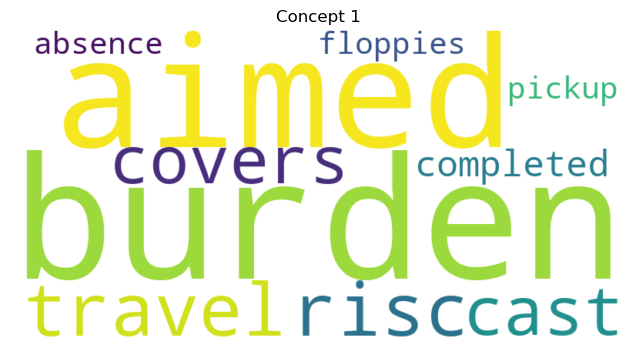

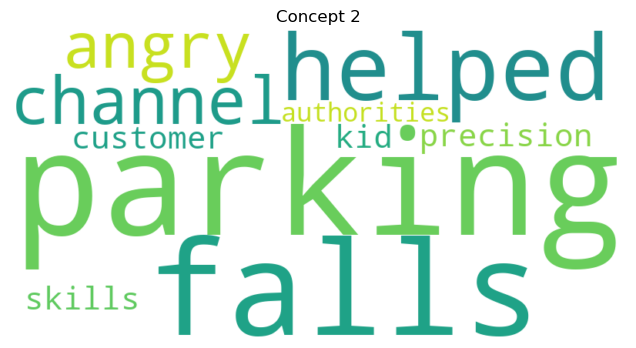

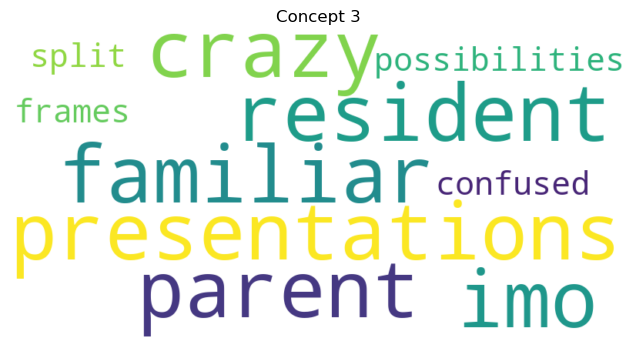

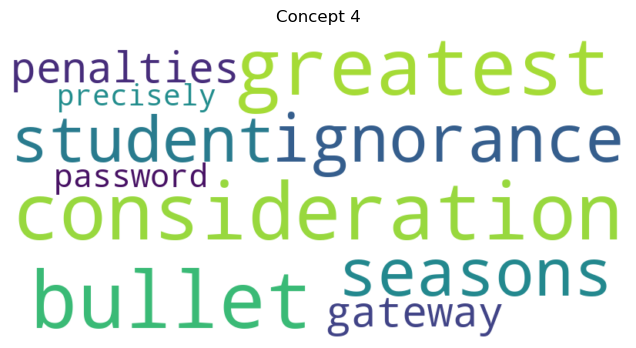

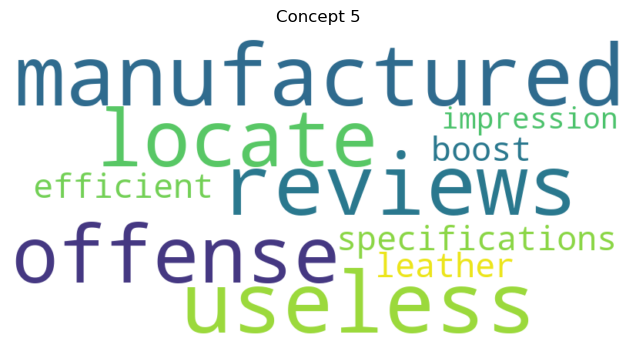

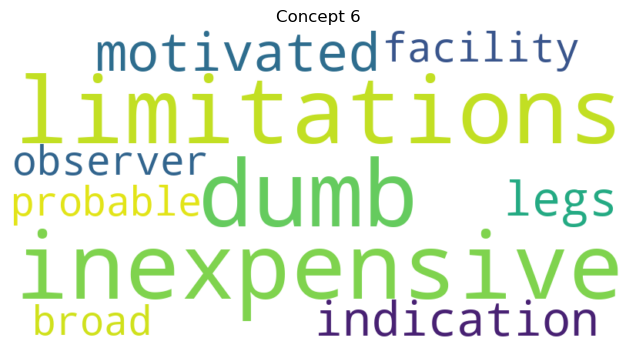

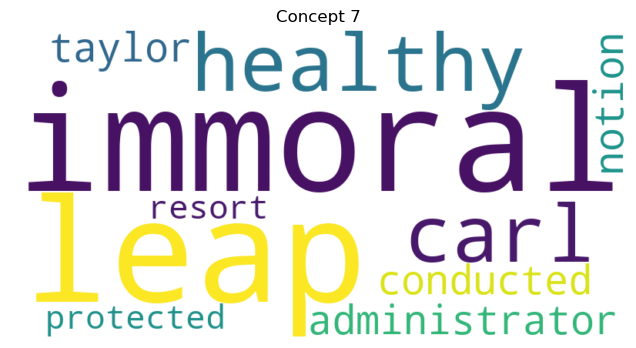

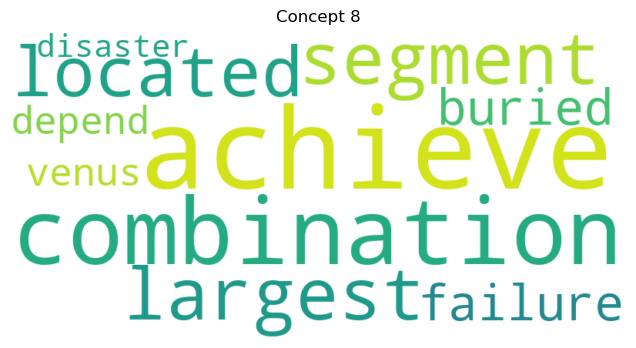

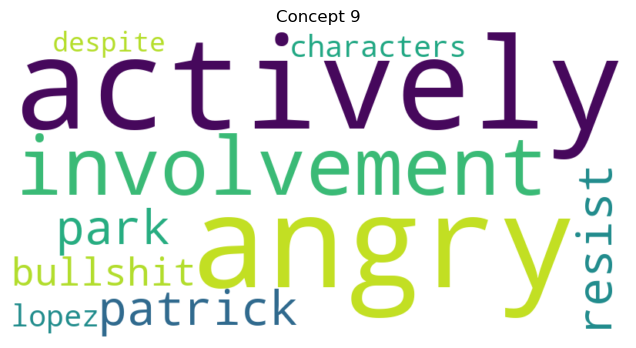

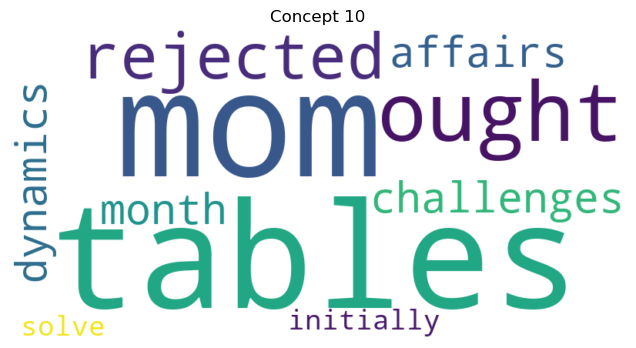

In [22]:
# ✅ 產生概念視覺化
gdcm.visualize()

In [23]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

def compute_coherence(concept_words_list, texts, method="c_v"):
    """
    計算概念內的詞彙 Coherence。
    
    Parameters:
    - concept_words_list: List[List[str]]，每個概念內的關鍵詞（`get_concept_words()` 提供）
    - texts: List[List[str]]，原始文本分詞（用於計算 Coherence）
    - method: "c_v", "c_uci", "c_npmi"（選擇不同 Coherence 方法）

    Returns:
    - coherence_scores: List[float]，每個概念的 Coherence 值
    """
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    coherence_scores = []
    for concept_words in concept_words_list:
        cm = CoherenceModel(topics=[concept_words], texts=texts, dictionary=dictionary, coherence=method)
        coherence_scores.append(cm.get_coherence())
    
    return coherence_scores

In [24]:
concept_words_list = gdcm.get_concept_words(top_k=10, concept_dist="cosine")  # 取得概念內的詞
texts = [text.split() for text in newsgroups_train.data]  # 轉換文本為 token
coherence_scores = compute_coherence(concept_words_list, texts, method="c_npmi")

for i, score in enumerate(coherence_scores):
    print(f"Concept {i+1} Coherence: {score:.4f}")

Concept 1 Coherence: -0.3866
Concept 2 Coherence: -0.3776
Concept 3 Coherence: -0.3815
Concept 4 Coherence: -0.3889
Concept 5 Coherence: -0.4050
Concept 6 Coherence: -0.3984
Concept 7 Coherence: -0.2860
Concept 8 Coherence: -0.3611
Concept 9 Coherence: -0.4051
Concept 10 Coherence: -0.3239


In [25]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_cosine_coherence(concept_words_list, word_vectors):
    """
    計算每個概念內詞向量的平均餘弦相似度，評估內聚性。

    Parameters:
    - concept_words_list: List[List[str]]，每個概念的關鍵詞
    - word_vectors: dict，詞向量字典，例如 Word2Vec/GloVe/BERT 的 embeddings

    Returns:
    - coherence_scores: List[float]，每個概念的平均相似度
    """
    coherence_scores = []
    
    for concept_words in concept_words_list:
        vectors = [word_vectors[word] for word in concept_words if word in word_vectors]
        
        if len(vectors) < 2:
            coherence_scores.append(0)  # 如果概念內少於 2 個詞，設為 0
            continue
        
        similarity_matrix = cosine_similarity(vectors)
        avg_similarity = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)].mean()
        coherence_scores.append(avg_similarity)
    
    return coherence_scores

In [26]:
# 獲取詞向量
word_vectors = {word: gdcm.embedding_i.weight.data.cpu().numpy()[idx] for idx, word in enumerate(vocab)}

# 計算 Coherence
cosine_coherence_scores = compute_cosine_coherence(concept_words_list, word_vectors)

for i, score in enumerate(cosine_coherence_scores):
    print(f"Concept {i+1} Cosine Coherence: {score:.4f}")

Concept 1 Cosine Coherence: 0.1313
Concept 2 Cosine Coherence: 0.1968
Concept 3 Cosine Coherence: 0.1497
Concept 4 Cosine Coherence: 0.1763
Concept 5 Cosine Coherence: 0.1553
Concept 6 Cosine Coherence: 0.1800
Concept 7 Cosine Coherence: 0.1618
Concept 8 Cosine Coherence: 0.1552
Concept 9 Cosine Coherence: 0.1680
Concept 10 Cosine Coherence: 0.1598


In [27]:
from itertools import combinations

def compute_jaccard_coherence(concept_words_list, texts):
    """
    計算 Jaccard Similarity 作為 Coherence 分數。
    
    Parameters:
    - concept_words_list: List[List[str]]，每個概念的關鍵詞
    - texts: List[List[str]]，原始文本分詞
    
    Returns:
    - coherence_scores: List[float]，每個概念的 Jaccard 相似度平均值
    """
    coherence_scores = []
    
    for concept_words in concept_words_list:
        pairs = list(combinations(concept_words, 2))  # 生成所有單詞對
        
        jaccard_scores = []
        for w1, w2 in pairs:
            docs_w1 = {i for i, doc in enumerate(texts) if w1 in doc}
            docs_w2 = {i for i, doc in enumerate(texts) if w2 in doc}
            
            intersection = len(docs_w1 & docs_w2)
            union = len(docs_w1 | docs_w2)
            
            if union == 0:
                jaccard_scores.append(0)
            else:
                jaccard_scores.append(intersection / union)
        
        coherence_scores.append(np.mean(jaccard_scores) if jaccard_scores else 0)
    
    return coherence_scores

In [28]:
jaccard_coherence_scores = compute_jaccard_coherence(concept_words_list, texts)

for i, score in enumerate(jaccard_coherence_scores):
    print(f"Concept {i+1} Jaccard Coherence: {score:.4f}")

Concept 1 Jaccard Coherence: 0.0079
Concept 2 Jaccard Coherence: 0.0110
Concept 3 Jaccard Coherence: 0.0065
Concept 4 Jaccard Coherence: 0.0129
Concept 5 Jaccard Coherence: 0.0069
Concept 6 Jaccard Coherence: 0.0138
Concept 7 Jaccard Coherence: 0.0151
Concept 8 Jaccard Coherence: 0.0119
Concept 9 Jaccard Coherence: 0.0094
Concept 10 Jaccard Coherence: 0.0108


In [29]:
from collections import defaultdict
import numpy as np

def compute_mimno_coherence(concept_words_list, texts):
    """
    Mimno 和 McCallum (2008) Coherence 計算方式，避免 division by zero 錯誤

    Parameters:
    - concept_words_list: List[List[str]]，每個概念的關鍵詞
    - texts: List[List[str]]，原始文本分詞後的列表

    Returns:
    - coherence_scores: List[float]，每個概念的 Coherence 值
    """
    # 記錄每個詞在哪些文件中出現
    doc_word_counts = defaultdict(set)  # 用 set 存儲詞的文件索引
    for i, text in enumerate(texts):
        for word in set(text):  # 轉換為 set，避免重複計數
            doc_word_counts[word].add(i)

    coherence_scores = []
    for concept_words in concept_words_list:
        pairs = [(w1, w2) for i, w1 in enumerate(concept_words) for w2 in concept_words[i+1:]]
        coherence = []
        for w1, w2 in pairs:
            D_w1 = len(doc_word_counts[w1])  # 包含 w1 的文件數量
            D_w1_w2 = len(doc_word_counts[w1] & doc_word_counts[w2])  # 同時包含 w1 和 w2 的文件數量
            
            # **防止 division by zero**
            if D_w1 == 0:
                continue  # 如果 w1 不在任何文檔中，跳過這個詞對
            
            score = np.log((D_w1_w2 + 1) / (D_w1 + 1e-10))  # 加一個小的數值避免除零錯誤
            coherence.append(score)

        coherence_scores.append(np.mean(coherence) if coherence else -np.inf)  # 避免空列表報錯

    return coherence_scores

In [30]:
mimno_coherence_scores = compute_mimno_coherence(concept_words_list, texts)

for i, score in enumerate(coherence_scores):
    print(f"Concept {i+1} Mimno Coherence: {score:.4f}")

Concept 1 Mimno Coherence: -0.3866
Concept 2 Mimno Coherence: -0.3776
Concept 3 Mimno Coherence: -0.3815
Concept 4 Mimno Coherence: -0.3889
Concept 5 Mimno Coherence: -0.4050
Concept 6 Mimno Coherence: -0.3984
Concept 7 Mimno Coherence: -0.2860
Concept 8 Mimno Coherence: -0.3611
Concept 9 Mimno Coherence: -0.4051
Concept 10 Mimno Coherence: -0.3239
